### """
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
All this in an effort to complete lab 1 for ATSC 528, Atmospheric Data Analysis. Looking to observe how different raidii of influence affect observations. 

"""
__author__    = "Charles A. Richie II"
__contact__   = "charles.richie@und.edu"

### WARNING! This code contains copious amounts of my sometimes dry sense of humor ###

In [1]:
### Import Required Modules (shouldn't need to change) ###
### Minor changes were made ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import os
import csv
import pandas as pd

In [2]:
### Read in observations and set the data up so a human can understand it...###
### Also, using pandas, since it apparently works better, when it decides to work that is. ###
file = open('RAOBs_201903131200.txt')
csvreader = csv.reader(file)
rows = []
for row in csvreader:
    rows.append(row)
rows


list_title = rows
df = pd.DataFrame(list_title, columns= ['Station ID', 'Lat', 'Long', '500 mb Height', '500 mb Wind Dir', '500 mb Wind Speed'])
obs_long = df['Long'].astype(float)
obs_lat = df['Lat'].astype(float)
### Now to make this in radians ###
obs_long_rad = obs_long*(np.pi/180)
obs_lat_rad = obs_lat*(np.pi/180)
height = df['500 mb Height'].astype(float)
height = np.array(height)

### Also, numerous errors keep saying np and pd are not defined....Spyder has no issue with this. ###
### Hashtag Spyder Supremacy. Hashtag Down with Jupyter. ###



In [3]:
### Set up analysis map with a 22x28 rectangular grid of points ###
### The magic begins here...setting all the stuff up ###
xo= 18.9
yo= -6.3
deltax= 1.27
deltay= 1.27

map_proj= 1/15e6
rho= 6371 * 1e5
lambdao= -115
psio= 60 * (np.pi/180)

x = np.arange(start = xo, stop = (deltax*22+18.9) -1, step = deltax)
y = np.arange(start = yo, stop = (deltay*28+-6.3)-1, step = deltay)

grid_x, grid_y = np.meshgrid(x,y)

[25.14618727 22.16243723 26.09166841 19.46031159 17.09435424 14.40009368
  6.05286737 14.41403809 12.72077995 16.56021129  3.13233218 22.9844841
 17.86946558 25.02010166  9.98386075 19.32921878 21.19078682 12.33740597
 15.56359807 17.00061122 21.91727344 20.69378516 15.21940721 27.66549619
 18.88775062 25.58945811 40.77215157 31.11193619 18.20292178 29.99626054
 16.61476878 36.03678903 25.4365251  39.95507791 16.68750546 23.93847959
 27.60913213 40.48370863 14.14239876 30.43077713 36.90049707 35.42337811
 33.98640991 47.2983383   9.7434409  27.82000918 36.59335702 21.36278411
 16.71589771 25.13375191 35.32369272 45.62464832 37.51151039 36.47830578
 44.9056349  43.6613456  36.55621593 44.94531637 29.5622763  32.39696588
 43.58871899 42.56808786 14.87917442 36.79320191 40.99223651 35.69700052
 41.03504331 29.92469305 37.45071921 29.65333733 32.9824296  23.96021466
 29.98482233 32.0239038  32.99049755 27.84813015 42.73377124 39.55454532
 37.86100219 37.48060231 38.96822223 34.87931338 42.

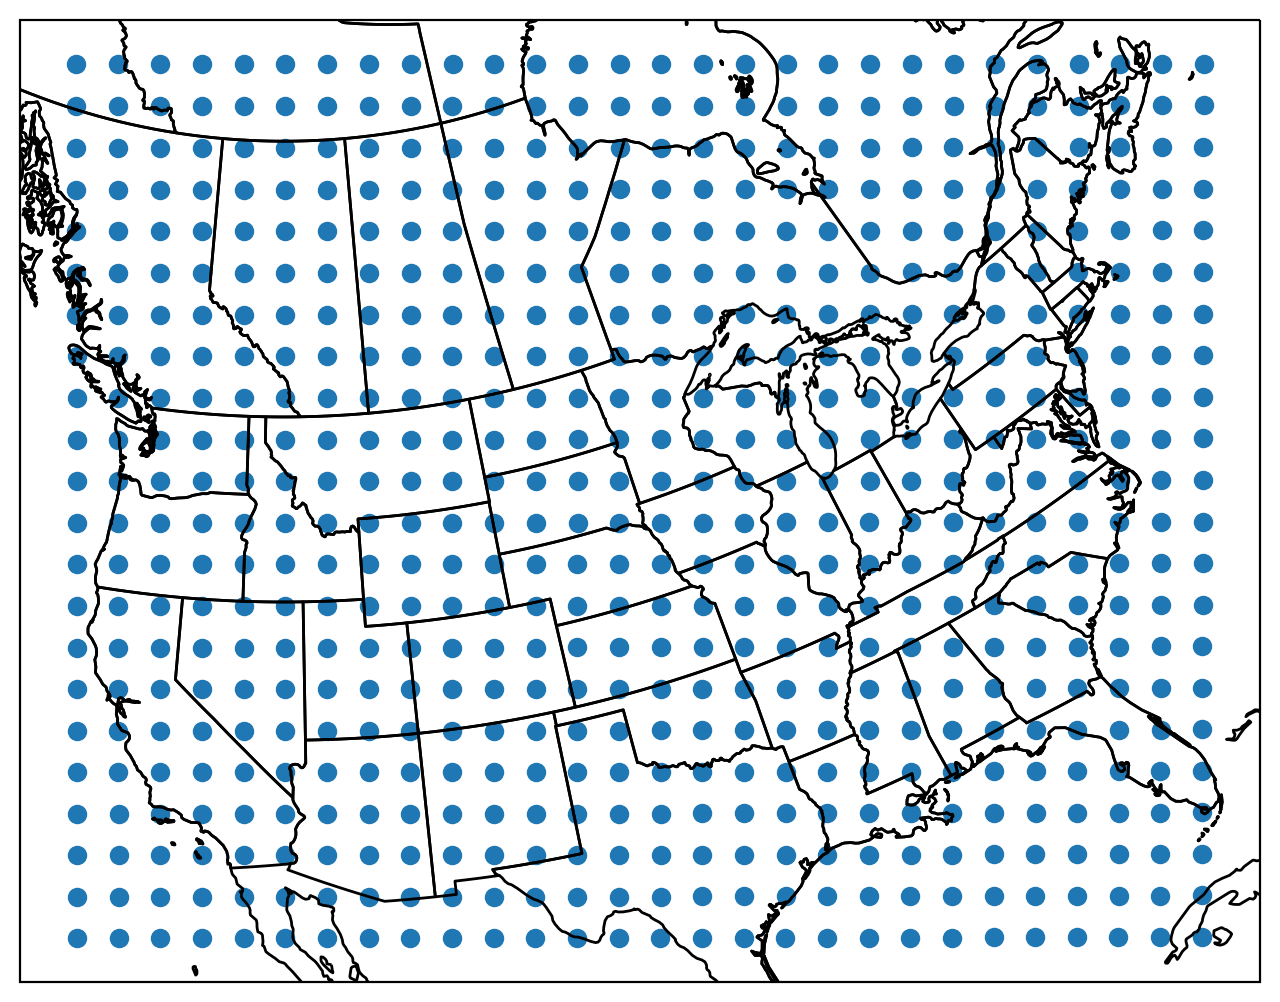

In [4]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
### Yup. Did that with the nasty multitude of parenthesis in equations ###

### Setting up the x,y as a Long/Lat Respectively ###
lons = np.arctan((grid_y/grid_x))*(180/(np.pi)) + lambdao
psi= (180/(np.pi))*(((np.pi)/2)-(2*(np.arctan((np.sqrt((grid_x/map_proj)**2 + (grid_y/map_proj)**2))/(rho*(1 + np.sin(psio)))))))

## Well, might as well plot this map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(lons.ravel(), psi.ravel(), transform = ccrs.PlateCarree())


### Now to get fancy with the equations from the NOAA Appendix. NOAA FTW ###

### Starting with the scale factor ###

sigma = (1+np.sin(psio))/(1+np.sin(obs_lat_rad))

###  Next to determine any latitude circle radii ###

radius = rho*sigma*(np.cos(obs_lat_rad))

### And finally latitude difference from the standard latitude ###

obs_lambda = ((obs_long_rad)-(lambdao*(np.pi/180)))

### Now to do x and y for observations, then lat/long those bad boys ###

obs_x = rho*sigma*(np.cos(obs_lat_rad))*(np.cos(obs_lambda))*map_proj
obs_y = rho*sigma*(np.cos(obs_lat_rad))*(np.sin(obs_lambda))*map_proj

obs_x = np.array(obs_x)
obs_y = np.array(obs_y)

### Testing ###

print (obs_x)
print (obs_y)

obs_long = np.arctan(obs_y/obs_x)*(180/np.pi)+lambdao
obs_lat = (180/(np.pi))*(((np.pi)/2)-(2*(np.arctan((np.sqrt((obs_x/map_proj)**2 + (obs_y/map_proj)**2))/(rho*(1 + np.sin(psio)))))))

### Will it work??? That's debatable... ###

print(obs_long)
print("Break Break Break Break Break Break Break Break Break")
print(obs_lat)

In [5]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

### Thanks to Gilchrist and Cressman, we have to build some matrices...yay...###
### This is about to get really nasty. I call the following code 'magic'...Rah, Rah Ravenclaw!  ###

R_value = np.array([10,20])

y_column = 28
x_row = 22
### Here's where the hoping and praying begins...and some crying over matrices ###
obs_mat = np.empty((y_column, x_row, len(R_value))) # Observation Matrix #
an_mat = np.empty((y_column, x_row, len(R_value))) # Analysis Matrix #

for i in range(len(R_value)):
    roi = R_value[i]
    for j in range(len(grid_x)):
        for k in range(len(grid_x[0])):
            xr = grid_x[j,k]-obs_x # distance in x direction #
            yr = grid_y[j,k]-obs_y # distance in y direction #
            # Now to make sure my data is within the bounds of the Radius of Influence (ROI) #
            rad = ((xr**2 + yr**2)**(1/2)) # Yes, I understand the exponents #
            index_ROI = np.where(rad <= roi)[0]
            
            # Setting the size of the matrix to the index #
            obs_mat[j,k,i] = len(index_ROI)
            
            # Now, make sure the data stay within the ROI. Using xk, yx, but should be read 'sub k" since we like k's #
            # Oh, and fo is 'f naught' #
            xk = xr[index_ROI]
            yk = yr[index_ROI]
            fo = height[index_ROI]
            fo = np.array(fo)
            
            # I labeled the following matrices A, B, and C in my notes...this was a foolish thing, since R, O, and C were used in class. #
            # So, to keep consistent with the rest of the class, I will use R, O, and C. Consistency is key...or something like that. #
            R = np.zeros((6,6))
            O = np.zeros(6)
            
            for q in range(len(yk)):
                r2 = np.matrix([1, xk[q], yk[q], xk[q]**2, yk[q]**2, xk[q]*yk[q]]) 
                r1 = r2.T # To Transpose #
                r = r1*r2
                R += np.array(r)
                O += np.array([fo[q], xk[q]*fo[q], yk[q]*fo[q], (xk[q]**2)*fo[q], (yk[q]**2)*fo[q], xk[q]*yk[q]*fo[q]])
                               
            R = R/obs_mat[j,k,i,]
            O = O/obs_mat[j,k,i]
            C = np.linalg.inv(np.matrix(R))*(np.matrix(O).T)
                               
            an_mat[j,k,i] = C[0,0] 
                               
            # I've drank the Kool-Aid, but this is where I drink whiskey, right?? #
                               
# Now to show this was not all for naught...not f naught...just normal naught #
                               
an_mat
                
            


array([[[5307.80658867, 5281.91764473],
        [5345.03976855, 5301.67936328],
        [5364.24743333, 5332.93567511],
        ...,
        [5820.56281212, 5835.31460787],
        [5854.20118384, 5896.81722301],
        [5994.24453815, 5964.4361651 ]],

       [[5309.58307501, 5282.27143644],
        [5327.22393849, 5306.29632699],
        [5358.32656086, 5332.87213014],
        ...,
        [5784.53975659, 5759.62975478],
        [5817.56441112, 5811.5319055 ],
        [5922.87584362, 5878.60856007]],

       [[5277.88514459, 5275.51738435],
        [5307.02283772, 5304.57940801],
        [5327.85078574, 5322.53905035],
        ...,
        [5705.7263106 , 5697.79236347],
        [5782.23796033, 5745.37428434],
        [5860.83822458, 5804.89411974]],

       ...,

       [[5444.5908621 , 5420.34475248],
        [5493.25097145, 5462.17198427],
        [5535.81519892, 5506.54807825],
        ...,
        [5888.19217558, 5909.48511312],
        [5870.67548678, 5917.30288903],
        [

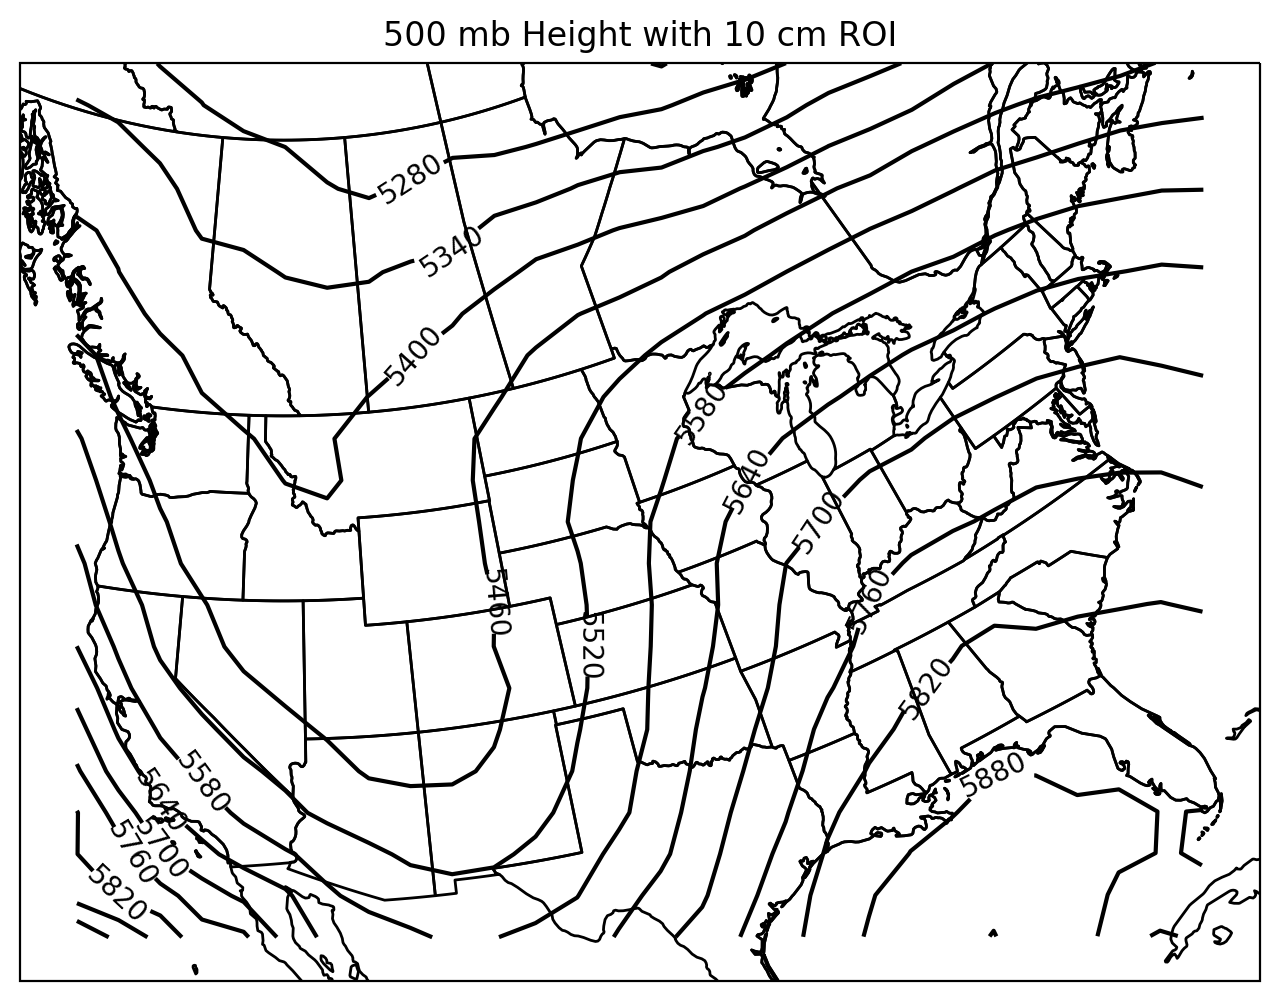

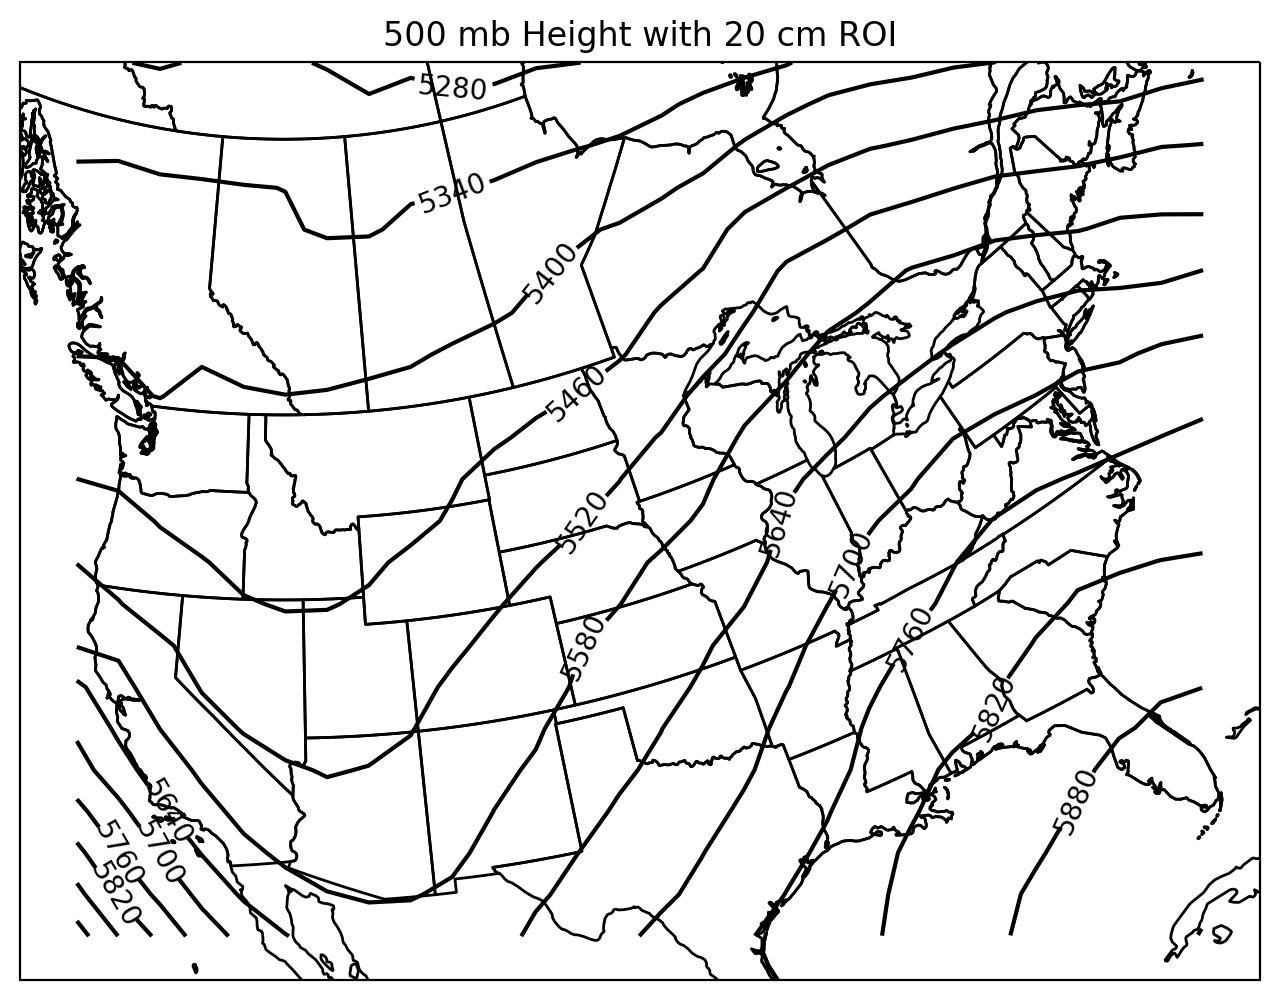

In [6]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height with 10 cm ROI")
plt.show()

### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height with 20 cm ROI")
plt.show()


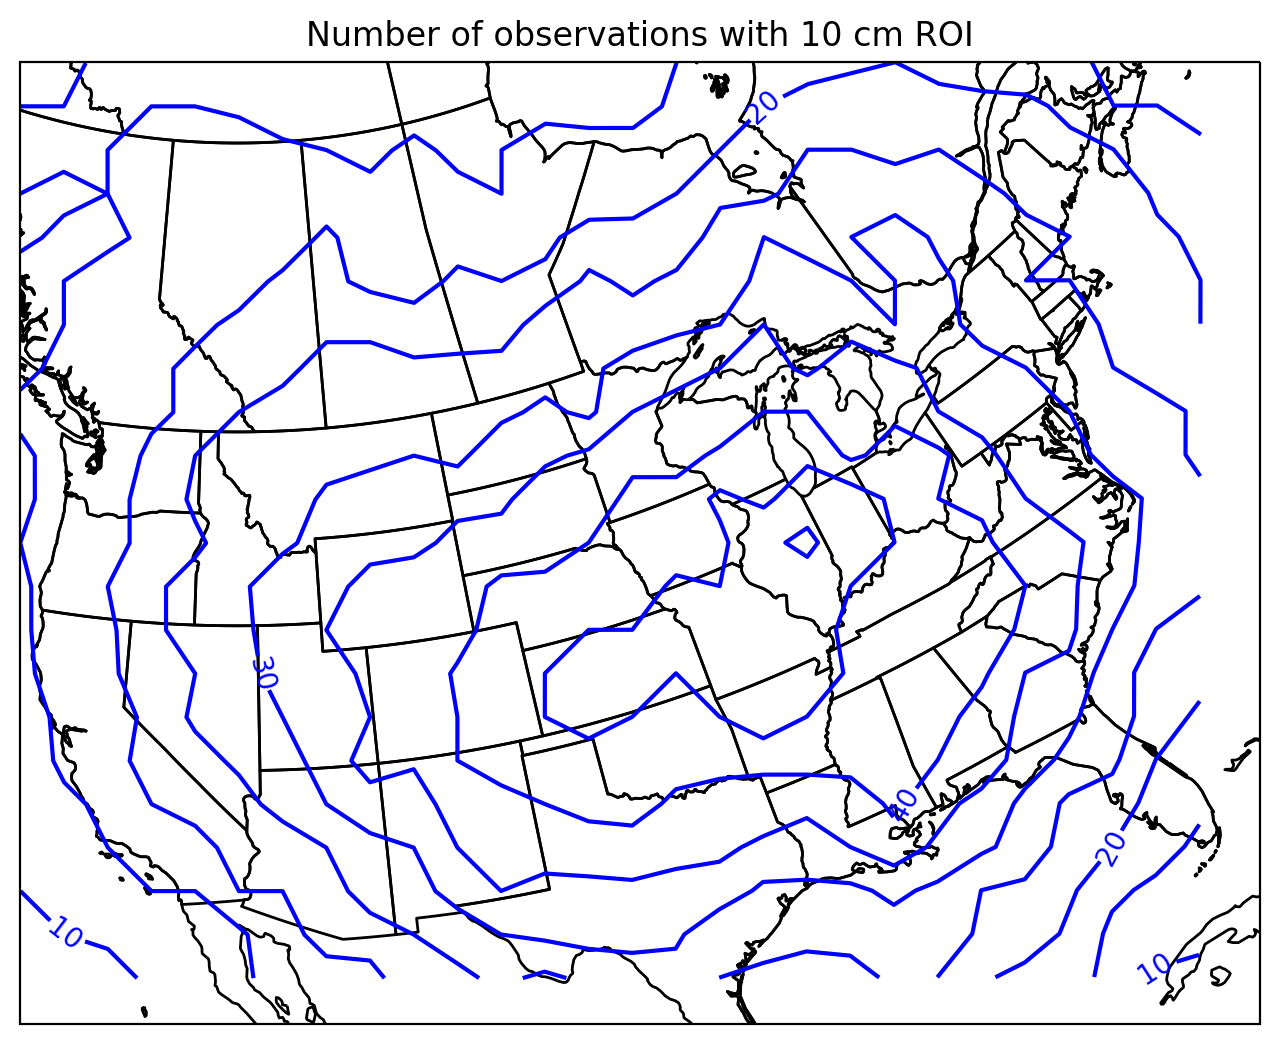

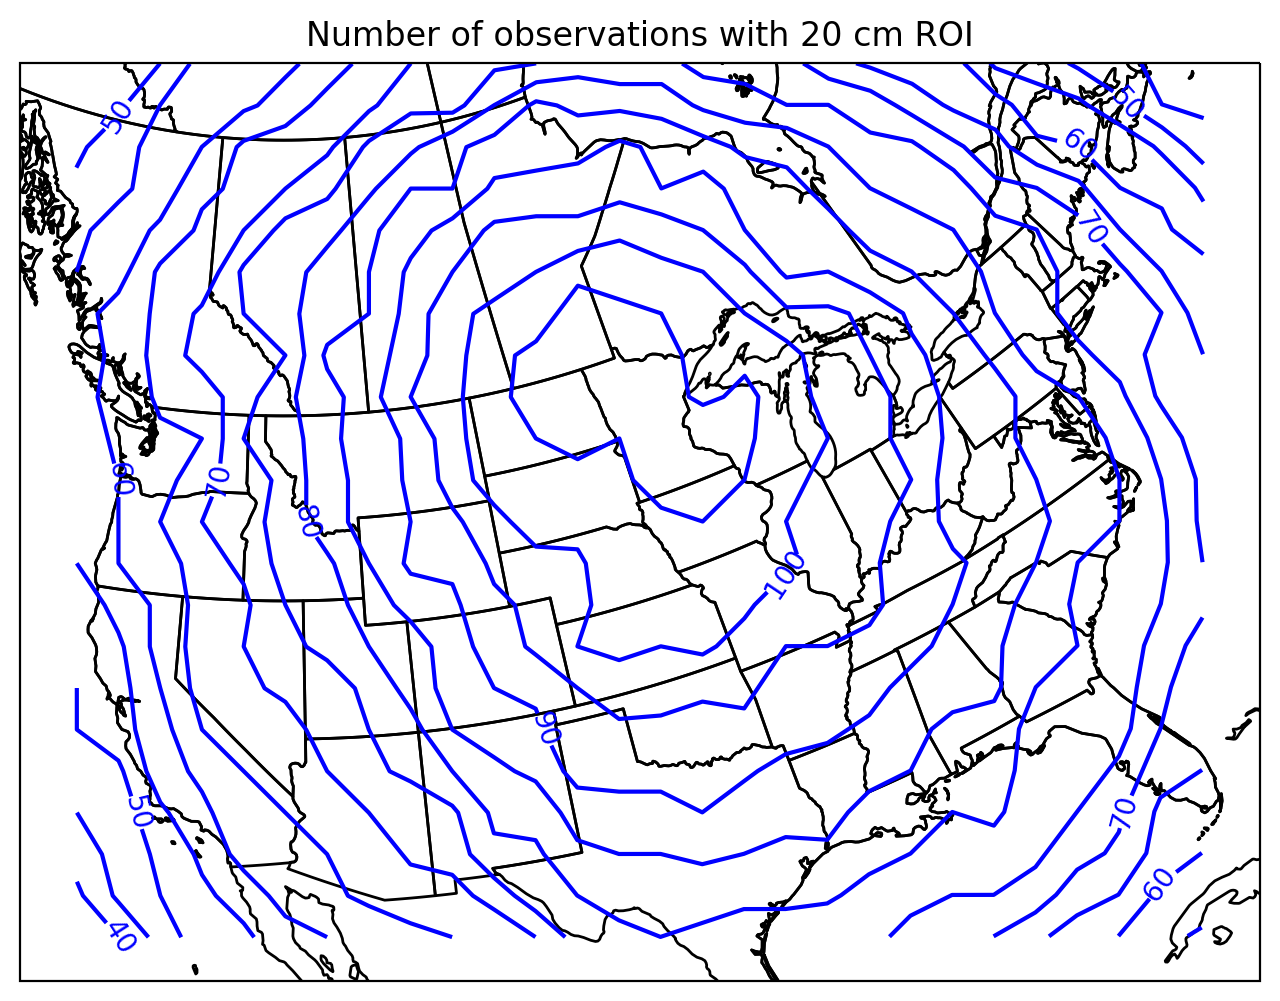

In [7]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
# Here goes nothing. First up for 10 cm ROI #
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lons,psi,obs_mat[:,:,0],colors='b',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title("Number of observations with 10 cm ROI")
plt.show()

# Now do 20 cm ROI #
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lons,psi,obs_mat[:,:,1],colors='b',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title("Number of observations with 20 cm ROI")
plt.show()

In [12]:
### Store the analyses in text files ###

np.savetxt("AnalysisMatrix.txt", an_mat[:,:,0], delimiter=',')
np.savetxt("ObsMatrix.txt", obs_mat[:,:,0], delimiter=',')

In [14]:
### Store the number of observations available for each grid point in text files ###
np.savetxt("AnalysisMatrix2.txt", an_mat[:,:,1], delimiter=',')
np.savetxt("ObsMatrix2.txt", obs_mat[:,:,1], delimiter=',')


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    
    There is a very pronounced trough over the western United States with a weak ridge over the southeast. Both show a bit of a jet streak off the coast of southern California. The 5400m height is further south into
    Montana and Idaho on the 10 cm run, but stays in Canada for the 20 cm run. 

2 - Describe the differences that you see in your contoured analyses.  
   Does one analysis seem to be smoother than the other?  If so, what would cause this?
   
   The 20 cm run looks much smoother compared to the 10 cm run. Of note, there is an oddly shaped feature near Florida on the 5880m line on the 10 cm run, which is smoothed out on the 20 cm run. 
   Also, notable the 5400m line stays higher on the 20 cm run. This is likely because the 20 cm run has more observations available inside each point's ROI, which may be averaging out smaller scale features. 
   
3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
    Results do not look realistic. There are several jumbled "shapes" over Canada, Cailfornia, and the Gulf of Mexico. I'm thinking the ROI is so low that there are no observations and voids are being created. 

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
    No. If you bring the value down to just one observation value, you would create a singular matrix, which cannot be inverted. 
    

'''